<a href="https://colab.research.google.com/github/HarshiniAiyyer/QuantOpt/blob/main/Quantum_Portfolio_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Part 1 : Setup

## Installing and importing libraries

In [2]:
!pip install -q qiskit qiskit_aer qiskit_algorithms qiskit_finance qiskit_optimization

In [5]:
from qiskit.circuit.library import TwoLocal
from qiskit.result import QuasiDistribution
from qiskit_aer.primitives import Sampler
from qiskit_algorithms import NumPyMinimumEigensolver, QAOA, SamplingVQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import YahooDataProvider
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_finance.exceptions import QiskitFinanceError
import numpy as np
import matplotlib.pyplot as plt
import datetime

### Getting data

Our tickers will be :  


> tickers = ['MARUTI.NS','RELIANCE.NS','HINDUNILVR.NS']



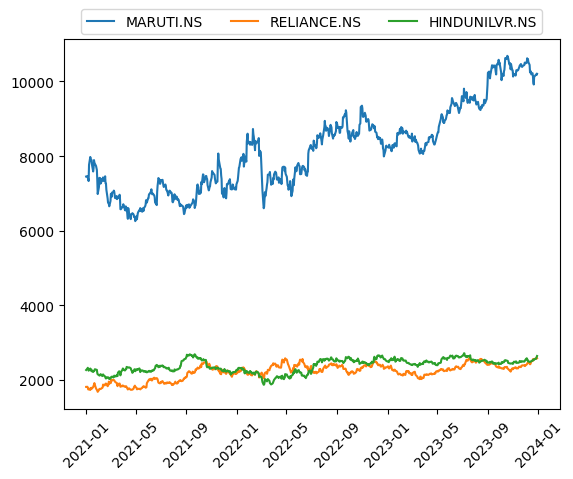

In [9]:
assets = 3
seed = 123

try:
    data = YahooDataProvider(
        tickers=['MARUTI.NS','RELIANCE.NS','HINDUNILVR.NS'],
        start=datetime.datetime(2021, 1, 1),
        end=datetime.datetime(2024, 1, 1),
    )
    data.run()
    for (cnt, s) in enumerate(data._tickers):
        plt.plot(data._data[cnt], label=s)
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=3)
    plt.xticks(rotation=45)
    plt.show()
except QiskitFinanceError as ex:
    data = None
    print(ex)

### Plotting covariance heatmap

In [10]:
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

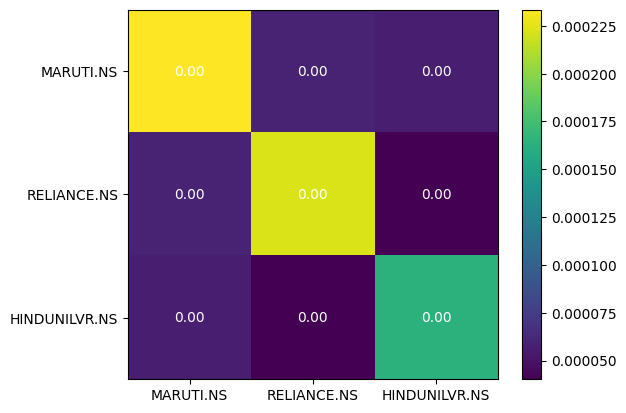

In [14]:
plt.imshow(sigma, interpolation="nearest")
plt.colorbar()
plt.xticks(range(len(data._tickers)), data._tickers)
plt.yticks(range(len(data._tickers)), data._tickers)
plt.show()

### Seek budget and penalty

In [16]:
q = 0.5  # set risk factor
budget = assets // 2  # set budget
penalty = assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()
qp

<QuadraticProgram: minimize 0.00011673205310485403*x_0^2 + 5.9748578413008094e..., 3 variables, 1 constraints, 'Portfolio optimization'>

### Function to describe Results in detail

In [17]:
def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = portfolio.to_quadratic_program().objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))

## Part 2: Using Algorithms

### The Classic Approach

- We use the function called Minimum Eigensolver of the Numpy library

In [18]:
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

print_result(result)

Optimal: selection [0. 1. 0.], value -0.0005

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
   [0 1 0]	-0.0005		1.0000


### Quantum Algorithms

#### (a) SamplingVQE -> Sampling Variational Quantum Eigensolver

In [20]:
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 1234

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(assets, "ry", "cz", reps=3, entanglement="full")
svqe_mes = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=cobyla)
svqe = MinimumEigenOptimizer(svqe_mes)
result = svqe.solve(qp)

print_result(result)

Optimal: selection [0. 1. 0.], value -0.0005

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
   [1 0 0]	-0.0004		0.7031
   [0 1 0]	-0.0005		0.1445
   [0 0 1]	-0.0002		0.0811
   [1 0 1]	-0.0006		0.0381
   [0 1 1]	-0.0006		0.0312
   [1 1 1]	-0.0010		0.0010
   [0 0 0]	0.0000		0.0010


#### (b) Solution using QAOA

In [21]:
algorithm_globals.random_seed = 1234

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
qaoa_mes = QAOA(sampler=Sampler(), optimizer=cobyla, reps=3)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)

Optimal: selection [0. 1. 0.], value -0.0005

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
   [0 1 0]	-0.0005		0.3369
   [1 0 0]	-0.0004		0.3164
   [0 0 1]	-0.0002		0.3008
   [0 0 0]	0.0000		0.0176
   [1 0 1]	-0.0006		0.0098
   [1 1 0]	-0.0008		0.0098
   [0 1 1]	-0.0006		0.0068
   [1 1 1]	-0.0010		0.0020
